<a href="https://colab.research.google.com/github/Nongbon/208499/blob/main/draft_lable_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/Nongbon/208499/main/ETH.csv

--2021-09-27 07:15:16--  https://raw.githubusercontent.com/Nongbon/208499/main/ETH.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 504403 (493K) [text/plain]
Saving to: ‘ETH.csv.1’

ETH.csv.1           100%[===================>] 492.58K  --.-KB/s    in 0.006s  

2021-09-27 07:15:16 (85.3 MB/s) - ‘ETH.csv.1’ saved [504403/504403]



In [2]:
!pip install pandas_ta

In [3]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib import dates as mpl_dates

In [4]:
data = pd.read_csv("ETH.csv").drop(["slug","name","symbol","ref_cur","time_open","time_close","time_high","time_low","id","market_cap"],axis=1)
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data = data.rename({'timestamp':'date'},axis=1)
data['date'] = data['date'].map(lambda x: x.rstrip('23:59:59'))
data['date'] = pd.to_datetime(data['date'])
data

,date,open,high,low,close,volume
0,2015-08-07,2.831620,3.536610,2.521120,2.772120,1.643290e+05
1,2015-08-08,2.793760,2.798810,0.714725,0.753325,6.741880e+05
2,2015-08-09,0.706136,0.879810,0.629191,0.701897,5.321700e+05
3,2015-08-10,0.713989,0.729854,0.636546,0.708448,4.052830e+05
4,2015-08-11,0.708087,1.131410,0.663235,1.067860,1.463100e+06
...,...,...,...,...,...,...
2232,2021-09-16,3613.073624,3673.310899,3489.805745,3571.294935,2.009390e+10
2233,2021-09-17,3569.568210,3589.305140,3356.449969,3398.538778,1.772236e+10
2234,2021-09-18,3397.422739,3540.807599,3371.892406,3432.018235,1.599522e+10
2235,2021-09-19,3433.287959,3448.322105,3286.172425,3329.447895,1.425761e+10


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2237 entries, 0 to 2236
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2237 non-null   datetime64[ns]
 1   open    2237 non-null   float64       
 2   high    2237 non-null   float64       
 3   low     2237 non-null   float64       
 4   close   2237 non-null   float64       
 5   volume  2237 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 105.0 KB


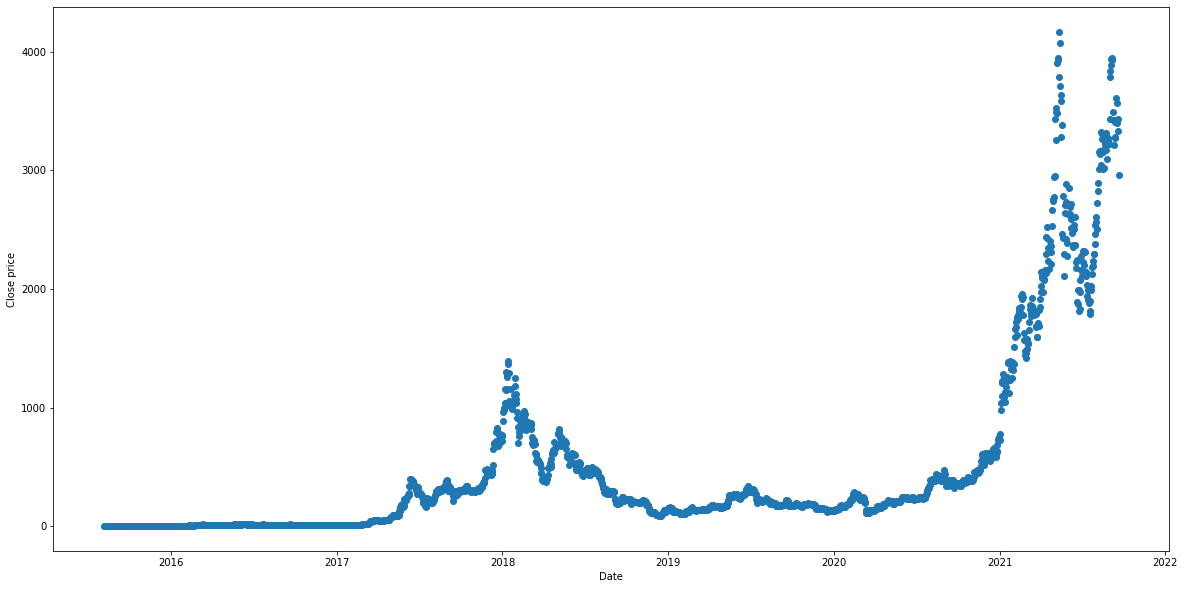

In [6]:
plt.figure(figsize=(20,10))
plt.plot_date(data['date'],data['close'])
plt.xlabel('Date')
plt.ylabel('Close price')
plt.show()

In [7]:
n = len(data)
n

2237

In [8]:
data['label'] = ''
for i in range(len(data)) :
  if i+1 < n :
    data['label'][i+1] = data['close'][i+1] / data['close'][i]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [9]:
data['Y'] = ''
for i in range(len(data)) :
  if i+1 < n :
    if data['label'][i+1] > 1 :
      data['Y'][i+1] = 1
    else : 
      data['Y'][i+1] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### **Input Indicator** 

In [10]:
t_period = 10

WMA 10

In [11]:
weights = np.arange(1,11)
weights

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [12]:
data['wma10'] = ''
data['wma10'] = data['close'].rolling(t_period).apply(lambda close: np.dot(close, weights)/weights.sum(), raw=True)

SMA 10

In [13]:
data['sma10'] = ''
data['sma10'] = data['close'].rolling(t_period).mean()

MACD

In [14]:
exp1 = data['close'].ewm(span = 12 , adjust = False , min_periods=12).mean()
exp2 = data['close'].ewm(span = 26 , adjust = False , min_periods=26).mean()
macd = exp1 - exp2
data['MACD'] = macd

Stochastic (%K) 14

In [15]:
k_period = 14
# Adds a "n_high" column with max value of previous 14 periods
n_high = data['high'].rolling(k_period).max()
# Adds an "n_low" column with min value of previous 14 periods
n_low = data['low'].rolling(k_period).min()
# Uses the min/max values to calculate the %k (as a percentage)
data['%K'] = (data['close'] - n_low)  / (n_high - n_low) * 100

RSI The first RS value requires the price from all 14 of the first trading days

In [16]:
def rsi(data, periods = 14, ema = True):
    """
    Returns a pd.Series with the relative strength index.
    """
    close_delta = data['close'].diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
	    # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

In [17]:
data['RSI'] = rsi(data, periods = 14, ema = True)

Williams (%R)

In [18]:
def get_wr(high, low, close, periods = 14):
    highh = high.rolling(14).max() 
    lowl = low.rolling(14).min()
    wr = -100 * ((highh - close) / (highh - lowl))
    return wr

data['%R'] = get_wr(data['high'], data['low'], data['close'], periods = 14)

## **Graph Indicator**

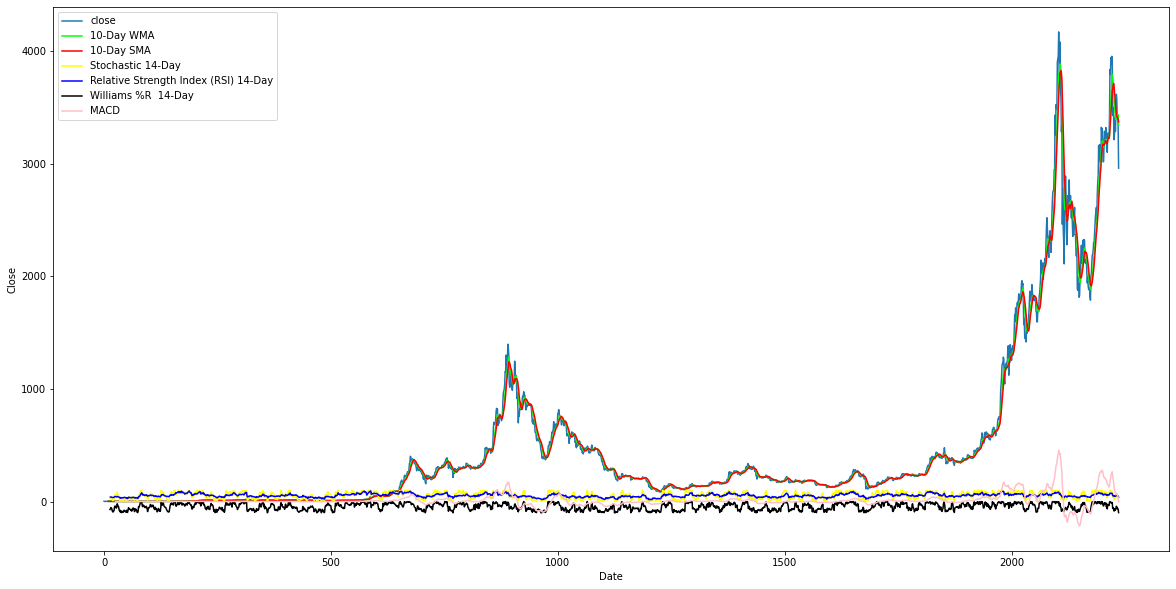

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(data['close'], label="close")
plt.plot(data['wma10'], label="10-Day WMA" , color='lime')
plt.plot(data['sma10'], label="10-Day SMA", color='red')
plt.plot(data['%K'], label="Stochastic 14-Day", color='yellow')
plt.plot(data['RSI'], label="Relative Strength Index (RSI) 14-Day", color='blue')
plt.plot(data['%R'], label="Williams %R  14-Day", color='Black')
plt.plot(data['MACD'], label="MACD", color='pink')
plt.xlabel("Date")
plt.ylabel("Close")
plt.legend()
plt.show()

## **Correlation Test**

In [ ]:
from scipy.stats import spearmanr
cor,p = spearmanr(data['Y'][13:],data['%K'][13:])
print(cor,p)

In [ ]:
data.corr()['close']

## **Feature Improtance**

In [19]:
data = data.dropna()
data

,date,open,high,low,close,volume,label,Y,wma10,sma10,MACD,%K,RSI,%R
25,2015-09-01,1.353480,1.392740,1.336630,1.351610,7.788620e+05,0.995119,0,1.260630,1.243478,-0.193357,58.589932,43.772935,-41.410068
26,2015-09-02,1.351570,1.354910,1.264620,1.294790,8.837690e+05,0.957961,0,1.269960,1.237698,-0.179722,47.101644,41.931344,-52.898356
27,2015-09-03,1.295190,1.309990,1.211030,1.264930,7.029910e+05,0.976938,0,1.274911,1.241064,-0.169373,41.064315,40.956172,-58.935685
28,2015-09-04,1.264930,1.302520,1.236810,1.274410,4.743910e+05,1.00749,1,1.280974,1.254486,-0.158579,51.275983,41.421951,-48.724017
29,2015-09-05,1.280560,1.342300,1.271190,1.338810,4.484530e+05,1.05053,1,1.296306,1.272369,-0.143177,79.621677,44.618160,-20.378323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2232,2021-09-16,3613.073624,3673.310899,3489.805745,3571.294935,2.009390e+10,0.987833,0,3437.158164,3414.422714,72.145158,53.014751,55.265103,-46.985249
2233,2021-09-17,3569.568210,3589.305140,3356.449969,3398.538778,1.772236e+10,0.951626,0,3434.270176,3411.637160,60.059565,36.677155,49.881616,-63.322845
2234,2021-09-18,3397.422739,3540.807599,3371.892406,3432.018235,1.599522e+10,1.00985,1,3437.975826,3405.107471,52.577081,40.328274,50.880232,-59.671726
2235,2021-09-19,3433.287959,3448.322105,3286.172425,3329.447895,1.425761e+10,0.970114,0,3424.219539,3395.318242,37.933318,29.488445,47.741694,-70.511555


In [20]:
from xgboost import XGBClassifier
model = XGBClassifier()
features = data[['wma10','sma10','MACD','%K','RSI','%R']].to_numpy()
print(features)         

[[ 1.26063035e+00  1.24347799e+00 -1.93357220e-01  5.85899322e+01
   4.37729355e+01 -4.14100678e+01]
 [ 1.26995981e+00  1.23769799e+00 -1.79722228e-01  4.71016440e+01
   4.19313436e+01 -5.28983560e+01]
 [ 1.27491109e+00  1.24106400e+00 -1.69373421e-01  4.10643153e+01
   4.09561715e+01 -5.89356847e+01]
 ...
 [ 3.43797583e+03  3.40510747e+03  5.25770814e+01  4.03282742e+01
   5.08802318e+01 -5.96717258e+01]
 [ 3.42421954e+03  3.39531824e+03  3.79333185e+01  2.94884447e+01
   4.77416938e+01 -7.05115553e+01]
 [ 3.34488777e+03  3.37006701e+03 -3.52392083e+00  1.80734667e+00
   3.85036872e+01 -9.81926533e+01]]


In [21]:
y = data['Y'].to_numpy()
print(y)

[0 0 0 ... 1 0 0]


In [22]:
model.fit(features,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

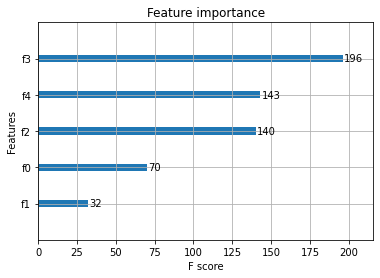

In [23]:
from xgboost import plot_importance
plot_importance(model)
pyplot.show()

In [36]:
importance = model.feature_importances_
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.09505
Feature: 1, Score: 0.11213
Feature: 2, Score: 0.12789
Feature: 3, Score: 0.54228
Feature: 4, Score: 0.12265
Feature: 5, Score: 0.00000


Feature: 0, Score: 0.12756
Feature: 1, Score: 0.11266
Feature: 2, Score: 0.16233
Feature: 3, Score: 0.11253
Feature: 4, Score: 0.20075
Feature: 5, Score: 0.28418


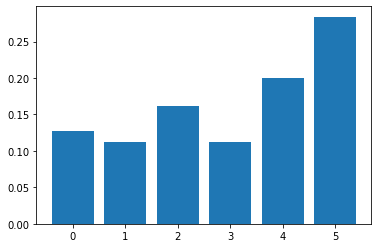

In [33]:
from sklearn.tree import DecisionTreeRegressor
model2 = DecisionTreeRegressor()
model2.fit(features,y)
importance2 = model2.feature_importances_
for i,v in enumerate(importance2):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance2))], importance2)
pyplot.show()

## **Model**